# AAE 450 Solar Power Cost Simulation
## Noah Stockwell

### Last reviewed 3/31/2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts

In [2]:
sns.set_theme()

## Define some convenience functions:
The first function creates a beta function with a given mode and average. The second function generates plots in a standard way.

In [3]:
def gen_beta(mode, avg):
    a = (-1 * avg + 2 * mode * avg) / (mode - avg)
    b = (a - 1 - (a - 2) * mode) / mode
    
    return sts.beta(a, b)

def gen_fig(data, fig_title):
    fig = plt.figure(figsize=(8, 6))
    ax = plt.gca()
    sns.histplot(data, stat='probability')
    ax.set_xlabel('Marginal Cost [$USD 2021/W]')
    ax.set_title(fig_title)
    
    return fig

## Model 1: Boeing 702 SP (2013)

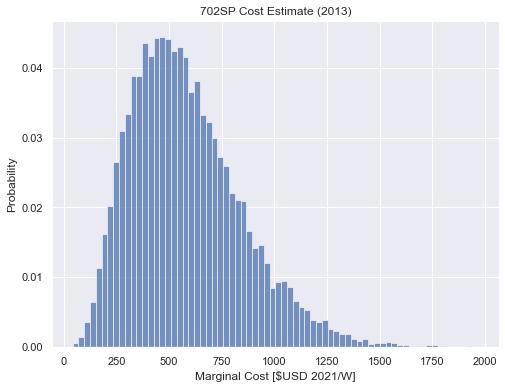

In [4]:
# https://spacenews.com/34454new-boeing-satellite-platform-drawing-lots-of-customer-interest/

# assuming beta distribution with 4% cost median, 5% avg [recurring]
# assuming 25% is development cost, over 45 vehicles, scaling for 100kW
sat_panels = 85000000 * gen_beta(.04, .05).rvs(size=2**14) / 5500 * .75
sat_panels_dev = sat_panels / 3 * 100 * 1000

fig = gen_fig(sat_panels, '702SP Cost Estimate (2013)')
fig.savefig('satellite_estimate.png', dpi=300)
pass

## Model 2: ISS Cost (2021)

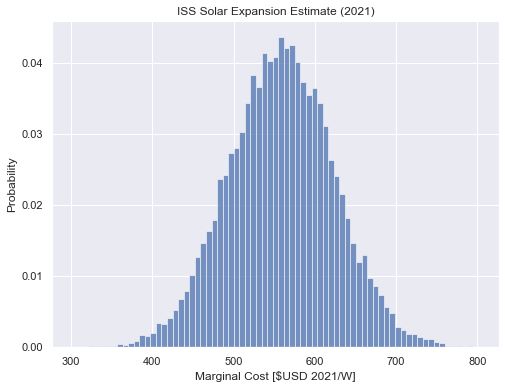

In [5]:
# https://spaceflightnow.com/2021/01/13/boeing-says-assembly-complete-on-first-set-of-new-space-station-solar-arrays/

# assuming normal distribution with 65% cost median, 7.5% standard deviation [recurring]
iss_panels1 = 103000000 * sts.norm.rvs(.65, .075, size=2**14) / 120000

# assuming 25% dev cost with 5% standard deviation
iss_panels1_dev = 103000000 * sts.norm.rvs(.25, .05, size=2**14)

fig = gen_fig(iss_panels1, 'ISS Solar Expansion Estimate (2021)')
fig.savefig('iss_estimate.png', dpi=300)
pass

## Model 3: NASA Estimate (1981)

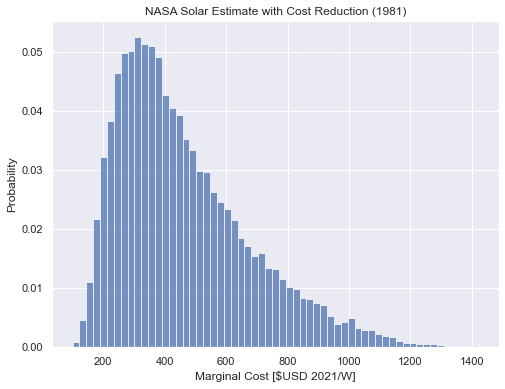

In [6]:
# https://ntrs.nasa.gov/citations/19810011645

# assuming a standard normal with $400 median, $75 std, brought forward to 2020 dollars
nse1 = sts.norm.rvs(400, 50, size=2**14) * 2.8655

# assuming a 1.5-5x reduction in cost (mode=2, average=3)
nse1 /= 10 * (.1 + gen_beta(.1, .2).rvs(size=2**14))

# assuming 100kW arrays at 25% development cost
nse1_dev = .25 * 100 * 1000 * nse1

fig = gen_fig(nse1, 'NASA Solar Estimate with Cost Reduction (1981)')
fig.savefig('nasa_estimate.png', dpi=300)
pass

## Perform Monte Carlo simulation for marginal cost:

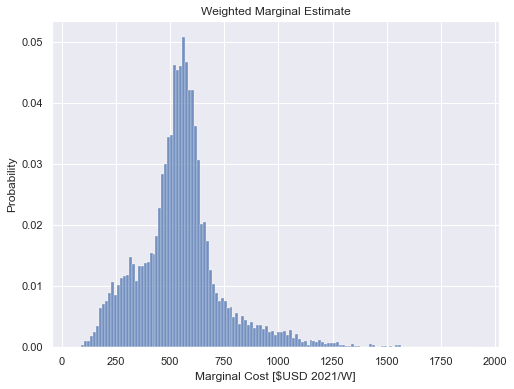

In [7]:
# Final Estimate

rng = np.random.default_rng()

pre_arr = [iss_panels1, sat_panels, nse1]
weights = np.array([5, 4, 2])

arrs = [None, None, None]
for i in range(len(pre_arr)):
    num_to_gen = int(2**14 / weights.sum() * weights[i])
    arrs[i] = pre_arr[i][rng.integers(0, 2**14, size=num_to_gen)]
    
res = np.hstack(arrs)

final_fig = gen_fig(res, 'Weighted Marginal Estimate')
pass

final_fig.savefig('res.png', dpi=300)

## Perform Monte Carlo simulation for development cost:

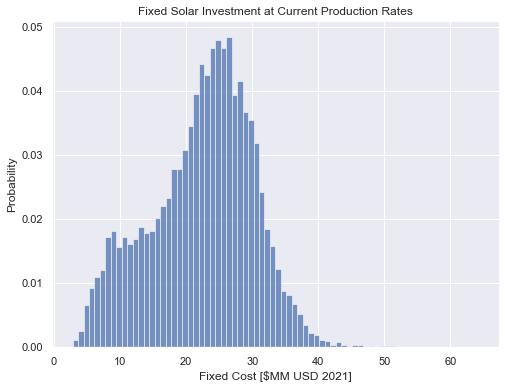

In [8]:
# Final Estimate Development

rng = np.random.default_rng()

pre_arr = [iss_panels1_dev, sat_panels_dev, nse1_dev]
weights = np.array([5, 2, 1])

arrs = [None, None, None]
for i in range(len(pre_arr)):
    num_to_gen = int(2**14 / weights.sum() * weights[i])
    arrs[i] = pre_arr[i][rng.integers(0, 2**14, size=num_to_gen)]
    
res_dev = np.hstack(arrs)

final_fig_dev = plt.figure(figsize=(8, 6))
ax = plt.gca()
sns.histplot(res_dev / 1e6, stat='probability')
ax.set_xlabel('Fixed Cost [$MM USD 2021]')
ax.set_title('Fixed Solar Investment at Current Production Rates')
pass

final_fig_dev.savefig('res_dev.png', dpi=300)

## Build a figure for expected fixed cost:

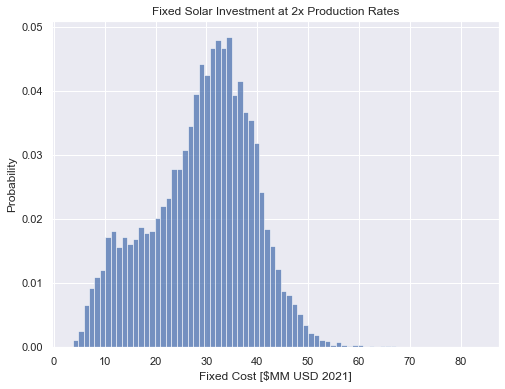

In [9]:
final_fig_dev = plt.figure(figsize=(8, 6))
ax = plt.gca()
sns.histplot(res_dev / 1e6 * ((2 - 1) * .3 + 1), stat='probability')
ax.set_xlabel('Fixed Cost [$MM USD 2021]')
ax.set_title('Fixed Solar Investment at 2x Production Rates')
pass

final_fig_dev.savefig('res_dev_speed.png', dpi=300)

## Produce a linearized model:

In [10]:
line_samples = 2 ** 4
x = np.repeat(np.linspace(20, 400, 25), line_samples)

rng = np.random.default_rng()

ms = rng.choice(res, size=x.shape[0], replace=True)
bs = rng.choice(res_dev, size=x.shape[0], replace=True) * ((2 - 1) * .3 + 1)

a = .9
top_ms = np.sort(ms)[int(ms.shape[0] * (.5 + a / 2) ** 2)] # $/kW
top_bs = np.sort(bs)[int(bs.shape[0] * (.5 + a / 2) ** 2)] # $

y = bs + x * ms * 1000

## Plot the linearized model:

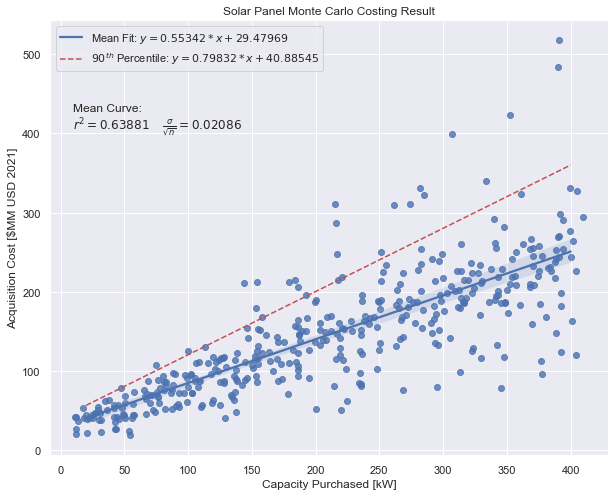

In [11]:
fig = plt.figure(figsize=(10, 8))
ax = plt.gca()
sns.regplot(x=x, y=y / 1e6, ci=99, x_jitter=10)
ax.set_xlabel('Capacity Purchased [kW]')
ax.set_ylabel('Acquisition Cost [$MM USD 2021]')
ax.set_title('Solar Panel Monte Carlo Costing Result')
lr = sts.linregress(ax.collections[0].get_offsets().data)
ytxt = np.ptp(ax.get_ylim()) * .75 + ax.get_ylim()[0]
ytxt2 = np.ptp(ax.get_ylim()) * .6 + ax.get_ylim()[0]
plt.text(10, ytxt, f"Mean Curve:\n$r^2={lr.rvalue**2:.5f}$    " + r"$\frac{\sigma}{\sqrt{n}}=$" + f"${lr.stderr:.5f}$")
plt.plot(x, (top_bs + x * top_ms * 1000) / 1e6, 'r--')
plt.legend([f'Mean Fit: $y={lr.slope:.5f}*x+{lr.intercept:.5f}$', 
            f'${100 * a:.0f}^{{th}}$ Percentile: $y={top_ms / 1e3:.5f}*x+{top_bs / 1e6:.5f}$'])

fig.savefig('linear_model.png', dpi=300)

## Small plot:
Create the same plot as above just smaller and without all the info

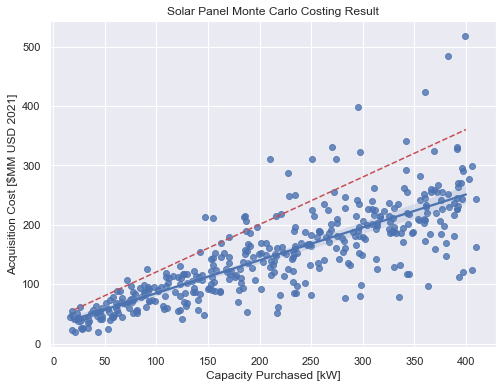

In [12]:
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()
sns.regplot(x=x, y=y / 1e6, ci=99, x_jitter=10)
ax.set_xlabel('Capacity Purchased [kW]')
ax.set_ylabel('Acquisition Cost [$MM USD 2021]')
ax.set_title('Solar Panel Monte Carlo Costing Result')
# lr = sts.linregress(ax.collections[0].get_offsets().data)
# ytxt = np.ptp(ax.get_ylim()) * .75 + ax.get_ylim()[0]
# ytxt2 = np.ptp(ax.get_ylim()) * .6 + ax.get_ylim()[0]
# plt.text(10, ytxt, f"Mean Curve:\n$r^2={lr.rvalue**2:.5f}$    " + r"$\frac{\sigma}{\sqrt{n}}=$" + f"${lr.stderr:.5f}$")
plt.plot(x, (top_bs + x * top_ms * 1000) / 1e6, 'r--')
# plt.legend([f'Mean Fit: $y={lr.slope:.5f}*x+{lr.intercept:.5f}$', 
#             f'${100 * a:.0f}^{{th}}$ Percentile: $y={top_ms / 1e3:.5f}*x+{top_bs / 1e6:.5f}$'])

fig.savefig('linear_model_small.png', dpi=300)